In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Begin out data processing class

In [4]:

REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

100%|██████████| 12501/12501 [01:10<00:00, 177.73it/s]
Cats: 12476
Dogs: 12470


In [5]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

24946


In [6]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

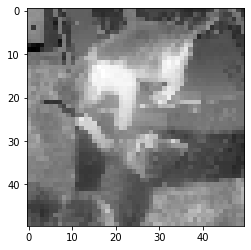

In [7]:
import matplotlib.pyplot as plt

plt.imshow(X[0], cmap="gray")

In [9]:
print(y[0])

tensor([1., 0.])


# Create our Convolutional Neural Network  

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # input: 1 image, 32 outptu channels, 5x5 window
        self.conv2 = nn.Conv2d(32, 64, 5) # input: 32, 64 output channels, 5x5 window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) # flattening
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out because we're doign 2 classes

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # View is reshape ... this flattens
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here
        return F.softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [12]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [13]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [14]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [15]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

22452 2494


In [16]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 225/225 [02:16<00:00,  1.64it/s]Epoch: 0. Loss: 0.22137877345085144



In [17]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:26<00:00, 94.03it/s] Accuracy:  0.613



In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

net = Net().to(device)

Running on the CPU


In [20]:
EPOCHS = 3

def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in range(0, len(train_X), BATCH_SIZE): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            #print(f"{i}:{i+BATCH_SIZE}")
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()

            optimizer.zero_grad()   # zero the gradient buffers
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update

        print(f"Epoch: {epoch}. Loss: {loss}")

train(net)

Epoch: 0. Loss: 0.2116153985261917
Epoch: 1. Loss: 0.16494008898735046
Epoch: 2. Loss: 0.11010196805000305


In [21]:
test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

test(net)

100%|██████████| 2494/2494 [00:16<00:00, 151.29it/s]Accuracy:  0.748



In [22]:
correct = 0
total = 0
for i in tqdm(range(0, len(test_X), BATCH_SIZE)):

    batch_X = test_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
    batch_y = test_y[i:i+BATCH_SIZE].to(device)
    batch_out = net(batch_X)

    out_maxes = [torch.argmax(i) for i in batch_out]
    target_maxes = [torch.argmax(i) for i in batch_y]
    for i,j in zip(out_maxes, target_maxes):
        if i == j:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 25/25 [00:13<00:00,  1.91it/s]Accuracy:  0.748



In [25]:
net = net.to(device)

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)

            matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
            in_sample_acc = matches.count(True)/len(matches)

            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)
        print("In-sample acc:",round(in_sample_acc, 2))

train(net)

  0%|          | 0/225 [00:00<?, ?it/s]tensor(0.1001, grad_fn=<MseLossBackward>)
In-sample acc: 0.87
  0%|          | 0/225 [00:00<?, ?it/s]tensor(0.1001, grad_fn=<MseLossBackward>)
In-sample acc: 0.87
100%|██████████| 225/225 [01:49<00:00,  2.06it/s]tensor(0.1001, grad_fn=<MseLossBackward>)
In-sample acc: 0.87



In [26]:
def batch_test(net):
    BATCH_SIZE = 100
    correct = 0
    total = 0
    with torch.no_grad():
        #np.random.shuffle(test_X)
        #np.random.shuffle(test_y)

        batch_X = test_X[:BATCH_SIZE].view(-1,1,50,50)
        batch_y = test_y[:BATCH_SIZE]

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad()
        outputs = net(batch_X)

        matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
        acc = matches.count(True)/len(matches)

        print("Test Accuracy:", round(acc, 3))


batch_test(net)

Test Accuracy: 0.74


In [27]:
def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

In [28]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            acc, loss = fwd_pass(batch_X, batch_y, train=True)

            print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")

            # just to show the above working, and then get out:
            if i == 5:
                break
            break

train(net)

  0%|          | 0/225 [00:00<?, ?it/s]Acc: 0.57  Loss: 0.2644



In [29]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                f.write(f"{MODEL_NAME},{int(time.time())},in_sample,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i == 5:
                    break
                break

train(net)

  0%|          | 0/225 [00:01<?, ?it/s]


In [30]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                f.write(f"{MODEL_NAME},{round(time.time(),3)},in_sample,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i == 5:
                    break
                break

train(net)

  0%|          | 0/225 [00:00<?, ?it/s]


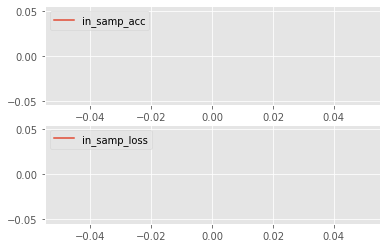

In [31]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1570490221" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, sample_type, acc, loss = c.split(",")

            times.append(timestamp)
            accuracies.append(acc)
            losses.append(loss)


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="in_samp_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="in_samp_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

In [32]:
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

0.49 tensor(0.2546, grad_fn=<MseLossBackward>)


In [33]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 10 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
train(net)

100%|██████████| 225/225 [02:30<00:00,  1.50it/s]


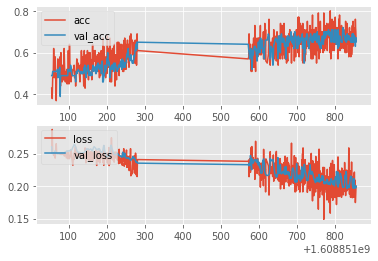

In [34]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = MODEL_NAME #"model-1570499409" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

In [35]:

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)
def train(net):
    BATCH_SIZE = 100
    EPOCHS = 30

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")
train(net)

100%|██████████| 225/225 [02:57<00:00,  1.27it/s]


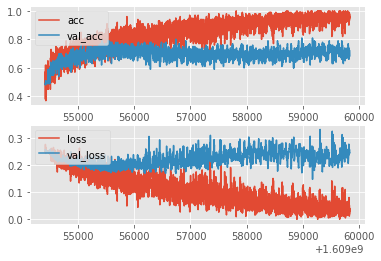

In [36]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1609054413" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)